In [2]:
import numpy as np
import math

# Gaussian Mixture Model

In [16]:
def _calculate_covariance_matrix(x, y=None):
        """Calculates covariance matrix XtX"""
        if y is None:
            y = x
        num_samples = x.shape[0]
        covariance_matrix = (1/(num_samples-1)) * (x - x.mean(axis=0)).T @ (y - y.mean(axis=0))
        return np.array(covariance_matrix, dtype=float)

class GaussianMixtureModel():
    """Probabilitstic clustering for Gaussian data
    Computes mean, covariance for clusters and assigns soft guesses
    (weights) for each sample.
    Uses Expectation-Maximisation algorithm to determine parameters
    Parameters
    ----------
    k: int
        Number of clusters
    max_iterations: int
        Max number of iterations for EM convergence
    tolerance: float
        Stop algorithm if change in parameters < tolerance
    """

    def __init__(self, num_clusters=2, max_iterations=500, tolerance=1e-8):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.parameters = []
        self.cluster_weights = None
        self.cluster_assignments = None
        #To check for convergence (keep appending over multiple iterations)
        self.cluster_weights_max = []

    def fit(self, x):
        """Fit parameters (mean, covariance, cluster weights)
        """
        # Initialise Gaussian distributions
        self._init_gaussians(x)

        # Run EM algorithm till convergence
        for _ in range(self.max_iterations):
            # Expectation step
            self._expectation(x)
            # Maximisation step
            self._maximisation(x)

            # Break if convergence
            if self._converged():
                break

    def predict(self, x):
        """Assign cluster assignments
        (after having fit the parameters)
        """
        self._expectation(x)
        return self.cluster_assignments
    
    def _init_gaussians(self, x):
        # Initialise Gaussian distributions randomly
        # Mean - random sample from X
        # Covariance - common for all classes
        num_samples = np.shape(x)[0]
        self.priors = (1/self.num_clusters) * np.ones(self.num_clusters)
        for i in range(self.num_clusters):
            params = {}
            params["mean"] = x[np.random.choice(range(num_samples))]
            params["covar"] = _calculate_covariance_matrix(x)
            self.parameters.append(params)
    
    def _expectation(self, x):
        """ E step of EM algorithm
        Calculate each sample's soft weights to different clusters
        """
        # Weight = posterior = likelihood * prior for each cluster
        posteriors = self._get_likelihoods(x) * self.priors
        sum_posteriors = np.expand_dims(np.sum(posteriors, axis=1), axis=1)
        self.cluster_weights = (posteriors/sum_posteriors)
        # Cluster assignments based on class with highest weight
        self.cluster_assignments = np.argmax(self.cluster_weights, axis=1)
        # Store weights across iterations to check for convergence
        self.cluster_weights_max.append(np.max(self.cluster_weights, axis=1))
    
    def _get_likelihoods(self, x):
        """ Get likelihood of data given parameters for each class"""
        num_samples = np.shape(x)[0]
        likelihoods = np.zeros((num_samples, self.num_clusters))
        for i in range(self.num_clusters):
            likelihoods[:, i] = self._multivariate_gaussian_likelihood(x, self.parameters[i])
        return likelihoods

    def _multivariate_gaussian_likelihood(self, x, params):
        """ Get prob density of Multivariate Gaussian distribution"""
        num_samples, num_features = np.shape(x)
        mean = params["mean"]
        covar = params["covar"]
        det = np.linalg.det(covar)
        mvn_likelihoods = np.zeros(num_samples)
        for i, sample in enumerate(x):
            coeff = 1 / ( (math.pow(2 * math.pi, num_features/2)) * (math.sqrt(det)) )
            exponent = np.exp(-0.5 * (sample-mean).T @ np.linalg.pinv(covar) @ (sample-mean) )
            mvn_likelihoods[i] = coeff * exponent
        return mvn_likelihoods

    def _maximisation(self, x):
        """ M-step of EM algorithm
        Determine, priors, means and covar of each class given soft weights of samples
        """
        for i in range(self.num_clusters):
            w = np.expand_dims(self.cluster_weights[:,i], axis=1)
            mean = (x * w).sum(axis=0) / w.sum()
            covar = (x - mean).T @ ((x - mean) * w) / w.sum()
            self.parameters[i]["mean"] = mean
            self.parameters[i]["covar"] = covar
        
        num_samples = np.shape(x)[0]
        self.priors = np.sum(self.cluster_weights, axis=0) / num_samples
    
    def _converged(self):
        """Check for convergence
        (If change in cluster weights is less than tol over 2 iterations)
        """
        if len(self.cluster_weights_max) < 2:
            return False
        diff = np.linalg.norm(self.cluster_weights_max[-1] - self.cluster_weights_max[-2])
        return diff <= self.tolerance

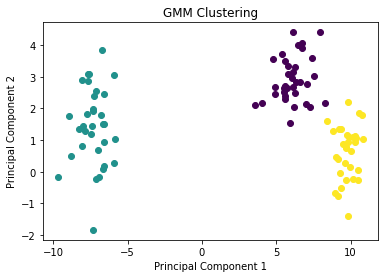

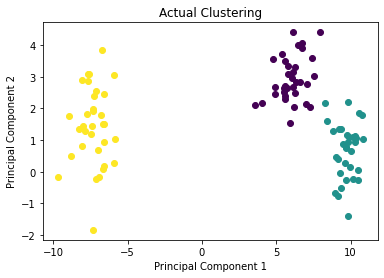

In [20]:
from sklearn import datasets

# Load the dataset
X, y = datasets.make_blobs()

# Cluster the data
clf = GaussianMixtureModel(num_clusters=3)
clf.fit(X)
y_pred = clf.predict(X)

p = Plot()
p.plot_in_2d(X, y_pred, title="GMM Clustering")
p.plot_in_2d(X, y, title="Actual Clustering")

In [1]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()